# Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [47]:
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

#import data analysis dependencies
import pandas as pd
import numpy as np

#import SQL Alchemy dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, Date

import datetime as dt

C:\Users\laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\laura\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\laura\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\laura\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\laura\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\laura\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\U

In [2]:
#create engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [16]:
Base = declarative_base()

Base.prepare(engine, reflect=True)

AttributeError: type object 'Base' has no attribute 'prepare'

In [17]:
class Measurements(Base):
    __tablename__ = 'measurements'

    id = Column(Integer, primary_key=True)
    station = Column(Text)
    date = Column(Date)
    prcp = Column(Float)  
    tobs = Column(Float)
    
class Stations(Base):
    __tablename__ = 'stations'

    id = Column(Integer, primary_key=True)
    station = Column(Text)
    name = Column(Text)
    latitude = Column(Float)  
    longitude = Column(Float)
    elevation = Column(Float) 

In [18]:
Base.metadata.create_all(engine)

In [19]:
conn = engine.connect()
inspector = inspect(engine)

In [20]:
from sqlalchemy.orm import Session
session = Session(bind=engine)

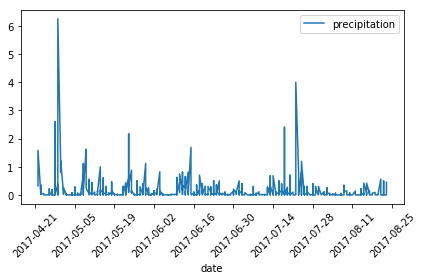

In [32]:
prev_year = dt.date.today() - dt.timedelta(days=365)

results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= prev_year).all()

df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

df.plot(x_compat=True)

plt.xticks(rotation='45')
plt.tight_layout()
plt.show()



In [36]:
#summary for precip data 
df.describe()

,precipitation
count,705.000000
mean,0.141390
std,0.393677
min,0.000000
25%,0.000000
50%,0.020000
75%,0.110000
max,6.250000


In [37]:
#count of stations 
session.query(func.count(Stations.station)).all()

[(9)]

In [39]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurements.station, func.count(Measurements.station)).\
    group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [41]:
# cal lowest temp, highest temp, avg temp from most active station
session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == 'USC00519281').all()

[(54, 85, 71.66378066378067)]

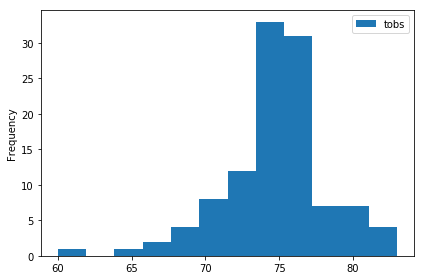

In [42]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date.today() - dt.timedelta(days=365)

results = session.query(Measurements.tobs).\
    filter(Measurements.station == 'USC00519281').\
    filter(Measurements.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

[(62, 69.57142857142857, 74)]


In [44]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62 68.36585365853658 74


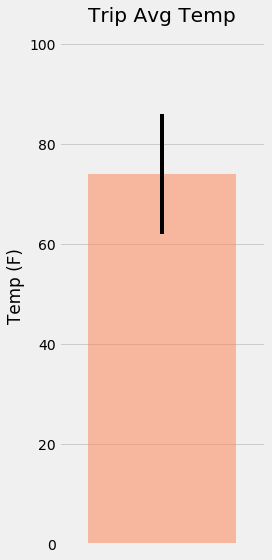

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
plt.tight_layout()
plt.show(1)

In [51]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2012-01-01'
end_date = '2012-01-07'

sel = [Stations.station, Stations.name, Stations.latitude, 
       Stations.longitude, Stations.elevation, func.sum(Measurements.prcp)]

results = session.query(*sel).\
    filter(Measurements.station == Stations.station).\
    filter(Measurements.date >= start_date).\
    filter(Measurements.date <= end_date).\
    group_by(Stations.name).order_by(func.sum(Measurements.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
